# EDA & Feature Ingestion For Disease Classification
In this notebook, we first carry out exploratory data analysis of the dataset used for building the disease classification model. We carry out various checks, encode labels, add additional features and so on.

Then, we create feature groups and ingest the features into AWS Sagemaker Featurestore. We also use Athena to run queries on the feature groups.
    
Finally, we split and save the available data for model training, validation and testing.

In [1]:
import boto3
import sagemaker
import pandas as pd
import numpy as np

sagemaker.config INFO - Fetched defaults config from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix


# Exploratory Data Analysis

In [13]:
train_val_df = pd.read_csv("s3://disease-classification-12052025/Training.csv")
test_df = pd.read_csv("s3://disease-classification-12052025/Testing.csv")

In [14]:
train_val_df.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,Unnamed: 133
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN


In [15]:
test_df.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Allergy
2,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,GERD
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chronic cholestasis
4,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Drug Reaction


The Training.csv file contained an extra column (located at position 134) which contains NaN

In [16]:
train_val_df.iloc[:,133].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Unnamed: 133, dtype: float64

In [17]:
# Drop the last column
train_val_df = train_val_df.drop(labels='Unnamed: 133',axis=1)

## Missing Value Check

In [18]:
missing_rows = train_val_df.isna().any(axis=1)
missing_rows.unique()

array([False])

Hence, none of the records have missing values

## Check for Duplicate Records

In [19]:
train_val_df[train_val_df.duplicated()]

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
5,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
6,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
7,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
8,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
9,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,(vertigo) Paroymsal Positional Vertigo
4916,0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,Acne
4917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Urinary tract infection
4918,0,1,0,0,0,0,1,0,0,0,...,0,0,1,1,1,1,0,0,0,Psoriasis


In [20]:
train_val_df.head(6)

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
5,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection


Many of the rows are ducplicates. For this application, it should be ok to keep them.

## Label Encoding

In [21]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
encoded = le.fit_transform(train_val_df['prognosis'])
train_val_df['Encoded_Labels'] = encoded

In [22]:
train_val_df = train_val_df.drop(labels="prognosis", axis=1)

In [23]:
train_val_df.shape

(4920, 133)

In [24]:
# Encode labels for test dataset
encoded_test = le.transform(test_df['prognosis'])
test_df['Encoded_Labels'] = encoded_test

# Drop prognosis column from test dataset
test_df = test_df.drop(labels="prognosis", axis=1)

## Checking Class Imbalance

In [25]:
val_count = train_val_df["Encoded_Labels"].value_counts()

Text(0.5, 1.0, 'Class distribution')

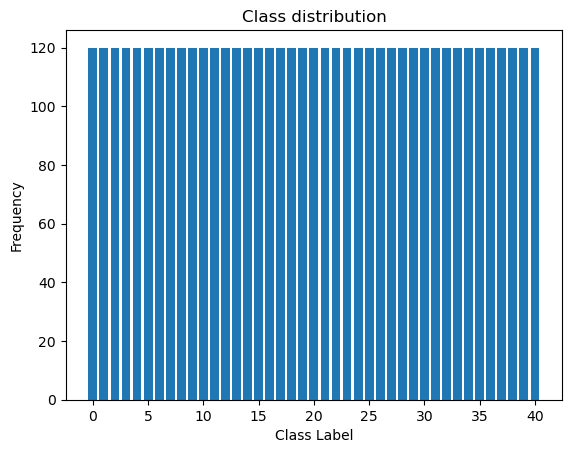

In [26]:
import matplotlib.pyplot as plt
plt.figure()
plt.bar(val_count.index, val_count.values)
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.title("Class distribution")

## Changing Feature Names
The feature names should satisfy regular expression pattern: [a-zA-Z0-9]([-_]*[a-zA-Z0-9]){0,63}
i.e, Start with an alphanumeric character
Followed by 63 groups with one or more - or _ and alphanumberic character

In this case, some changes are made to the column names to adhere to the above rules and also avoid multiple __

In [27]:
# Replace space in column names with underscore
train_val_df.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

# Remove brackets in column names
train_val_df.rename(columns=lambda x: x.replace('(', ''), inplace=True)
train_val_df.rename(columns=lambda x: x.replace(')', ''), inplace=True)

# Removing full stop in column names
train_val_df.rename(columns=lambda x: x.replace('.', ''), inplace=True)

# Removing multiple underscore together at the end of column names
train_val_df.rename(columns=lambda x: x.replace('__', '_'), inplace=True)

# Removing underscore at the end of column names
train_val_df.columns = train_val_df.columns.str.rstrip('_')

In [28]:
# Replace space in column names with underscore
test_df.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

# Remove brackets in column names
test_df.rename(columns=lambda x: x.replace('(', ''), inplace=True)
test_df.rename(columns=lambda x: x.replace(')', ''), inplace=True)

# Removing full stop in column names
test_df.rename(columns=lambda x: x.replace('.', ''), inplace=True)

# Removing multiple underscore together at the end of column names
test_df.rename(columns=lambda x: x.replace('__', '_'), inplace=True)

# Removing underscore at the end of column names
test_df.columns = test_df.columns.str.rstrip('_')

## Creating Record Identifier
This is for the purpose of feature store

In [29]:
train_val_df['Record_ID'] = range(1, len(train_val_df) + 1)
test_df['Record_ID'] = range(1, len(test_df) + 1)

## Adding event time column to dataframes
This is for the purpose of feature store

In [30]:
import time
current_time_sec  = int(round(time.time()))

event_time_feature_name = "event_time"

train_val_df[event_time_feature_name] = pd.Series(
    [current_time_sec] * len(train_val_df), dtype="float64"
)
test_df[event_time_feature_name] = pd.Series(
    [current_time_sec] * len(test_df), dtype="float64"
)

# Ingest Data into FeatureStore
In this section, we create two feature groups to store the features for training and testing the model.

In [22]:
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.feature_store.feature_store import FeatureStore

## Creation of Feature Groups

In [20]:
region = "us-east-2"
boto_session = boto3.Session(region_name=region)
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
#region = sagemaker_session.boto_region_name
#default_bucket = "disease-classification-11262025"
#prefix = 'features'
#offline_feature_store_bucket = 's3://*{}*/*{}*'.format(default_bucket, prefix)

sagemaker_client = boto_session.client(service_name='sagemaker', region_name=region)
featurestore_runtime = boto_session.client(service_name='sagemaker-featurestore-runtime', region_name=region)

feature_store_session = sagemaker.session.Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime
)

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix


In [23]:
# Create feature groups
#session = sagemaker.Session()
train_val_feature_group_name = "disease_classification_train_val_features"
train_val_feature_group = FeatureGroup(name=train_val_feature_group_name, 
                                       sagemaker_session = feature_store_session)

test_feature_group_name = "disease_classification_test_features"
test_feature_group = FeatureGroup(name=test_feature_group_name, 
                                  sagemaker_session = feature_store_session)

Now, only a feature group instance has been created. It hasn't created anything in AWS yet. The steps for that are done subsequently.

Check the datatypes of all the columns. These would be used in feature definitions. Do necessary changes in this step. Ex: If 'object' dtype, change it to string 

In [25]:
unique_dtypes_train_val_df = train_val_df.dtypes.apply(lambda x: x.name).unique()
print(unique_dtypes_train_val_df)
unique_dtypes_test_df = test_df.dtypes.apply(lambda x: x.name).unique()
print(unique_dtypes_test_df)

['int64' 'float64']
['int64' 'float64']


In [ ]:
# Display the dtypes for each column
#for col in test_df.columns:
#print(col, " : ", test_df.dtypes[col])

In [26]:
role = "arn:aws:iam::657480822269:role/service-role/AmazonSageMakerAdminIAMExecutionRole"
print(role)

arn:aws:iam::657480822269:role/service-role/AmazonSageMakerAdminIAMExecutionRole


In [27]:
sagemaker.get_execution_role()

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix


'arn:aws:iam::657480822269:role/service-role/AmazonSageMakerAdminIAMExecutionRole'

In [28]:
#Define the Schema and Create Feature Group in AWS
train_val_feature_group.load_feature_definitions(train_val_df) # Uses schema of the dataframe

[FeatureDefinition(feature_name='itching', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='skin_rash', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='nodal_skin_eruptions', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='continuous_sneezing', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='shivering', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='chills', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='joint_pain', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='stomach_pain', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefi

In [29]:
test_feature_group.load_feature_definitions(test_df) # Uses schema of the dataframe

[FeatureDefinition(feature_name='itching', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='skin_rash', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='nodal_skin_eruptions', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='continuous_sneezing', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='shivering', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='chills', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='joint_pain', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='stomach_pain', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefi

In [38]:
s3_uri_train_val = "s3://disease-classification-12052025/features/"


record_identifier_name = "Record_ID"

train_val_feature_group.create(s3_uri=s3_uri_train_val, 
                     record_identifier_name = record_identifier_name, 
                     event_time_feature_name = event_time_feature_name,
                     role_arn=role,
                     enable_online_store=False)

{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-2:657480822269:feature-group/disease_classification_train_val_features',
 'ResponseMetadata': {'RequestId': '924855ca-64b3-47e1-baf4-2652578e8b32',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '924855ca-64b3-47e1-baf4-2652578e8b32',
   'strict-transport-security': 'max-age=47304000; includeSubDomains',
   'x-frame-options': 'DENY',
   'content-security-policy': "frame-ancestors 'none'",
   'cache-control': 'no-cache, no-store, must-revalidate',
   'x-content-type-options': 'nosniff',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '118',
   'date': 'Sat, 06 Dec 2025 02:50:55 GMT'},
  'RetryAttempts': 0}}

In [39]:
s3_uri_test_val = "s3://disease-classification-12052025/features-test/"
test_feature_group.create(s3_uri=s3_uri_test_val, 
                     record_identifier_name = record_identifier_name, 
                     event_time_feature_name = event_time_feature_name,
                     role_arn=role,
                     enable_online_store=True)

{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-2:657480822269:feature-group/disease_classification_test_features',
 'ResponseMetadata': {'RequestId': '19fd75b4-f042-46ef-a1b6-cf7503034389',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '19fd75b4-f042-46ef-a1b6-cf7503034389',
   'strict-transport-security': 'max-age=47304000; includeSubDomains',
   'x-frame-options': 'DENY',
   'content-security-policy': "frame-ancestors 'none'",
   'cache-control': 'no-cache, no-store, must-revalidate',
   'x-content-type-options': 'nosniff',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '113',
   'date': 'Sat, 06 Dec 2025 02:51:01 GMT'},
  'RetryAttempts': 0}}

In [40]:
# Check feature group status
def wait_for_feature_group_creation_complete(feature_group):
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        time.sleep(5)
        status = feature_group.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Failed to create feature group {feature_group.name}")
    print(f"FeatureGroup {feature_group.name} successfully created.")

wait_for_feature_group_creation_complete(train_val_feature_group)
wait_for_feature_group_creation_complete(test_feature_group)


FeatureGroup disease_classification_train_val_features successfully created.
Waiting for Feature Group Creation
FeatureGroup disease_classification_test_features successfully created.


In [41]:
feature_groups = sagemaker.Session().sagemaker_client.list_feature_groups()

for fg in feature_groups['FeatureGroupSummaries']:
    print(fg['FeatureGroupName'])

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
trial3
trial
training-feature-group-06-02-18-18
testing-feature-group-06-02-18-18
disease_classification_train_val_features
disease_classification_test_features


In [42]:
sagemaker = boto3.client("sagemaker")
feature_groups  = sagemaker.list_feature_groups()
for fg in feature_groups['FeatureGroupSummaries']:
    print(fg['FeatureGroupName'])

trial3
trial
training-feature-group-06-02-18-18
testing-feature-group-06-02-18-18
disease_classification_train_val_features
disease_classification_test_features


## Ingest Data to Feature Groups

This is to push data into feature store

In [43]:
train_val_feature_group.ingest(data_frame = train_val_df, max_workers=1, wait = True)

IngestionManagerPandas(feature_group_name='disease_classification_train_val_features', feature_definitions={'itching': {'FeatureName': 'itching', 'FeatureType': 'Integral'}, 'skin_rash': {'FeatureName': 'skin_rash', 'FeatureType': 'Integral'}, 'nodal_skin_eruptions': {'FeatureName': 'nodal_skin_eruptions', 'FeatureType': 'Integral'}, 'continuous_sneezing': {'FeatureName': 'continuous_sneezing', 'FeatureType': 'Integral'}, 'shivering': {'FeatureName': 'shivering', 'FeatureType': 'Integral'}, 'chills': {'FeatureName': 'chills', 'FeatureType': 'Integral'}, 'joint_pain': {'FeatureName': 'joint_pain', 'FeatureType': 'Integral'}, 'stomach_pain': {'FeatureName': 'stomach_pain', 'FeatureType': 'Integral'}, 'acidity': {'FeatureName': 'acidity', 'FeatureType': 'Integral'}, 'ulcers_on_tongue': {'FeatureName': 'ulcers_on_tongue', 'FeatureType': 'Integral'}, 'muscle_wasting': {'FeatureName': 'muscle_wasting', 'FeatureType': 'Integral'}, 'vomiting': {'FeatureName': 'vomiting', 'FeatureType': 'Integr

In [44]:
test_feature_group.ingest(data_frame = test_df,
                               max_workers = 1,
                               wait = True)

IngestionManagerPandas(feature_group_name='disease_classification_test_features', feature_definitions={'itching': {'FeatureName': 'itching', 'FeatureType': 'Integral'}, 'skin_rash': {'FeatureName': 'skin_rash', 'FeatureType': 'Integral'}, 'nodal_skin_eruptions': {'FeatureName': 'nodal_skin_eruptions', 'FeatureType': 'Integral'}, 'continuous_sneezing': {'FeatureName': 'continuous_sneezing', 'FeatureType': 'Integral'}, 'shivering': {'FeatureName': 'shivering', 'FeatureType': 'Integral'}, 'chills': {'FeatureName': 'chills', 'FeatureType': 'Integral'}, 'joint_pain': {'FeatureName': 'joint_pain', 'FeatureType': 'Integral'}, 'stomach_pain': {'FeatureName': 'stomach_pain', 'FeatureType': 'Integral'}, 'acidity': {'FeatureName': 'acidity', 'FeatureType': 'Integral'}, 'ulcers_on_tongue': {'FeatureName': 'ulcers_on_tongue', 'FeatureType': 'Integral'}, 'muscle_wasting': {'FeatureName': 'muscle_wasting', 'FeatureType': 'Integral'}, 'vomiting': {'FeatureName': 'vomiting', 'FeatureType': 'Integral'},

In [47]:
train_val_feature_group_uri = (
    train_val_feature_group.describe()
    .get("OfflineStoreConfig")
    .get("S3StorageConfig")
    .get("ResolvedOutputS3Uri")
)
print(train_val_feature_group_uri)

train_val_feature_group_s3_prefix = train_val_feature_group_uri.replace(
    f"s3://disease-classification-12052025/", ""
)

s3_client = boto3.client('s3')
offline_store_contents = None
n=1
while offline_store_contents is None:
    objects_in_bucket = s3_client.list_objects(
        Bucket="disease-classification-12052025", Prefix=train_val_feature_group_s3_prefix
    )
    if "Contents" in objects_in_bucket and len(objects_in_bucket["Contents"]) > 1:
        offline_store_contents = objects_in_bucket["Contents"]
        print("Data available.")
    else:
        print("Waiting for data in offline store...\n")
        time.sleep(5)
        n=n+1
    if n>2:
        break


s3://disease-classification-12052025/features/657480822269/sagemaker/us-east-2/offline-store/disease_classification_train_val_features-1764989454/data
Data available.


In [48]:
test_feature_group_uri = (
    test_feature_group.describe()
    .get("OfflineStoreConfig")
    .get("S3StorageConfig")
    .get("ResolvedOutputS3Uri")
)
print(test_feature_group_uri)

test_feature_group_s3_prefix = test_feature_group_uri.replace(
    f"s3://disease-classification-12052025/", ""
)

s3_client = boto3.client('s3')
offline_store_contents = None
n=1
while offline_store_contents is None:
    objects_in_bucket = s3_client.list_objects(
        Bucket="disease-classification-12052025", Prefix=test_feature_group_s3_prefix
    )
    if "Contents" in objects_in_bucket and len(objects_in_bucket["Contents"]) > 1:
        offline_store_contents = objects_in_bucket["Contents"]
        print("Data available.")
    else:
        print("Waiting for data in offline store...\n")
        time.sleep(5)
        n=n+1
    if n>2:
        break

s3://disease-classification-12052025/features-test/657480822269/sagemaker/us-east-2/offline-store/disease_classification_test_features-1764989461/data
Data available.


To confirm that data has been ingested, we can quickly retrieve a record from the online store:

In [52]:
featurestore_runtime = boto_session.client(service_name='sagemaker-featurestore-runtime', region_name=region)

record = featurestore_runtime.get_record(
    FeatureGroupName="disease_classification_test_features",
    RecordIdentifierValueAsString=str(12)
)

print(record)

{'ResponseMetadata': {'RequestId': 'b105101f-4274-4374-bda3-e1b2bb79b014', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'b105101f-4274-4374-bda3-e1b2bb79b014', 'content-type': 'application/json', 'content-length': '10624', 'date': 'Sat, 06 Dec 2025 03:20:32 GMT'}, 'RetryAttempts': 0}, 'Record': [{'FeatureName': 'itching', 'ValueAsString': '0'}, {'FeatureName': 'skin_rash', 'ValueAsString': '0'}, {'FeatureName': 'nodal_skin_eruptions', 'ValueAsString': '0'}, {'FeatureName': 'continuous_sneezing', 'ValueAsString': '0'}, {'FeatureName': 'shivering', 'ValueAsString': '0'}, {'FeatureName': 'chills', 'ValueAsString': '0'}, {'FeatureName': 'joint_pain', 'ValueAsString': '0'}, {'FeatureName': 'stomach_pain', 'ValueAsString': '0'}, {'FeatureName': 'acidity', 'ValueAsString': '1'}, {'FeatureName': 'ulcers_on_tongue', 'ValueAsString': '0'}, {'FeatureName': 'muscle_wasting', 'ValueAsString': '0'}, {'FeatureName': 'vomiting', 'ValueAsString': '0'}, {'FeatureName': 'burning_micturition

## Querying Offline Store using Athena

In [54]:
train_val_query = train_val_feature_group.athena_query()

In [55]:
train_val_table_name = train_val_query.table_name
print(train_val_table_name) # Table name in Glue Data Catalog

disease_classification_train_val_features_1764989454


In [56]:
query_string = f"SELECT * from {train_val_table_name} LIMIT 5"

In [57]:
train_val_query.run(query_string= query_string, output_location="s3://disease-classification-12052025/query-output")

'0d63d3fa-f276-4db6-95d1-dc1f2a75c997'

In [58]:
data = train_val_query.as_dataframe()

In [59]:
data

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,encoded_labels,record_id,event_time,write_time,api_invocation_time,is_deleted
0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,4,18,1.764989e+09,2025-12-06 02:57:50.158,2025-12-06 02:52:45.000,False
1,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,16,23,1.764989e+09,2025-12-06 02:57:45.946,2025-12-06 02:52:45.000,False
2,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,15,6,1.764989e+09,2025-12-06 02:57:50.101,2025-12-06 02:52:45.000,False
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,9,31,1.764989e+09,2025-12-06 02:57:50.101,2025-12-06 02:52:45.000,False
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,62,1.764989e+09,2025-12-06 02:57:50.101,2025-12-06 02:52:45.000,False


# Create training, validation and test data

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
X_train_val_df = train_val_df.iloc[:,:132]
y_train_val_df = train_val_df.iloc[:,132]

X_train, X_val, y_train, y_val = train_test_split(X_train_val_df, y_train_val_df, test_size=0.2, random_state=21,
                                                  shuffle=True, stratify=y_train_val_df)

In [33]:
X_test = test_df.iloc[:,:132]
y_test = test_df.iloc[:,132]

In [36]:
train_df_to_write = pd.concat([y_train, X_train], axis=1)
val_df_to_write = pd.concat([y_val, X_val], axis=1)
test_df_to_write = pd.concat([y_test, X_test], axis=1)

In [14]:
train_file = "train.csv"
val_file = "val.csv"
test_file = "test.csv"

In [37]:
train_df_to_write.to_csv(train_file, index=False, header=False)
val_df_to_write.to_csv(val_file, index=False, header=False)
test_df_to_write.to_csv(test_file, index=False, header=False)

In [5]:
bucket = "disease-classification-12052025"

In [39]:
s3 = boto3.client('s3')
s3.upload_file(train_file, bucket, f"data/{train_file}")
s3.upload_file(val_file, bucket, f"data/{val_file}")
s3.upload_file(test_file, bucket, f"data/{test_file}")